<a href="https://colab.research.google.com/github/joSanchez28/BERT_on_tweets/blob/master/5_Evaluaci%C3%B3n_de_modelos_y_an%C3%A1lisis_de_entrenamientos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluación de los modelos y análisis de sus entrenamientos.
En esta libreta nos disponemos a evaluar los mejores modelos que hemos obtenido en las libretas anteriores y a comparar su eficacia. Además, analizaremos los datos que recopilamos en sus respectivos entrenamientos.


Cargamos en primer lugar los paquetes necesarios.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "/content/drive/My Drive/Colab Notebooks/lectura_y_preprocesado.py" .

In [3]:
!pip install scikit-plot

In [4]:
pip install transformers

In [0]:
import os
import pandas as pd
import re
import time
import pickle
import numpy as np
import sklearn
import scikitplot as skplt
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
#from tensorflow import keras
#import tensorflow_datasets
from lectura_y_preprocesado import *

## 1- Carga del modelo BERT y evaluación en los conjuntos de test.

En esta sección, cargaremos el modelo BERT ya entrenado en la libreta 2. En concreto cogeremos aquel que mostraba un mayor *accuracy* en el conjunto de validación. Tras cargar el modelo lo evaluaremos en los conjuntos de test que tenemos. Trabajamos con dos conjuntos de test. El primero de ellos es el que conformamos en la libreta 1, y está hecho a partir de tweets etiquetados según los emoticonos que contienen. El segundo de ellos ha sido etiquetado de forma manual (es por ello que es interesante ver la evaluación del modelo en ambos conjuntos).

Intentamos cargar el modelo BERT ya entrenado con tweets.


In [0]:
models_dir = "/content/drive/My Drive/Modelos_finales/" #Para ejecutarlo en Google Colab con Google Drive
#models_dir = "../Modelos_finales" #Para ejecutarlo localmente
model_name = "my_best_model_BERT.02-0.86.h5"
model_path = models_dir + model_name

In [0]:
model_BERT, tokenizer, config = carga_modelo_BERT(model_path)

Cargamos los datos del primer conjunto de test y lo preprocesamos como es requerido por nuestro modelo BERT (y como ya hicimos en la libreta 2).


In [0]:
dataset_name = "test_set.csv"
dataset_path = "/content/drive/My Drive/Datos/" + dataset_name
#dataset_path = "../Datos/" + dataset_name
test1_df = pd.read_csv(dataset_path)

In [0]:
test1_df = preprocesa_para_BERT(test1_df)

In [10]:
test1_df.head(4)

,idx,label,sentence
0,0,0,USER Sorry to hear your mate news my thoughts ...
1,1,1,USER you can send some of that Purple Turtle G...
2,2,0,Getting ready for my calc class
3,3,1,USER Not sure...I'll check it out and let you ...


In [0]:
data_test = tf.data.Dataset.from_tensor_slices(test1_df.to_dict('list'))

In [0]:
test_dataset = glue_convert_examples_to_features(data_test, tokenizer, max_length=40, task="sst-2") #O:128

In [0]:
TEST_BATCH_SIZE = 32 * 2
test_dataset = test_dataset.batch(TEST_BATCH_SIZE)

Y evaluamos el modelo sobre este primer conjunto de test


In [15]:
loss1_BERT, acc1_BERT = model_BERT.evaluate(test_dataset)#, batch_size=TEST_BATCH_SIZE)
print('Test loss:', loss1_BERT)
print('Test accuracy:', acc1_BERT)

2500/2500 [==============================] - 352s 141ms/step - loss: 0.3339 - accuracy: 0.8628
Test loss: 0.33390891551971436
Test accuracy: 0.8627874851226807


Hacemos lo mismo con el segundo conjunto de test (el cual ha sido etiquetado de forma manual y tiene tan solo 359 tweets).

In [0]:
# DATASET DECODING
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

dataset_name = "testdata.manual.2009.06.14.csv"
dataset_path = "/content/drive/My Drive/Datos/" + dataset_name
#dataset_path = "../Datos/" + dataset_name
test2_df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Nos quedamos solo con los comentarios positivos o negativos (ignoramos los neutros porque estos no los usan en el paper original).

In [17]:
test2_df = test2_df[test2_df["target"]!=2]
test2_df["target"].value_counts()

4    182
0    177
Name: target, dtype: int64

Preprocesamos como es requerido por nuestro modelo BERT (y como ya hicimos en la libreta 2).


In [0]:
test2_df = preprocesa_para_BERT(test2_df)

In [19]:
test2_df.head(4)

,idx,label,sentence
0,0,1,USER I loooooooovvvvvveee my Kindle2. Not that...
1,1,1,Reading my kindle2... Love it... Lee childs is...
2,2,1,"Ok, first assesment of the #kindle2 ...it fuck..."
3,3,1,USER You'll love your Kindle2. I've had mine f...


In [0]:
data_test = tf.data.Dataset.from_tensor_slices(test2_df.to_dict('list'))

In [0]:
test_dataset = glue_convert_examples_to_features(data_test, tokenizer, max_length=40, task="sst-2") #O:128

In [0]:
TEST_BATCH_SIZE = 32 * 2
test_dataset = test_dataset.batch(TEST_BATCH_SIZE)

Y evaluamos el modelos sobre este segundo conjunto de test 'manual'.

In [23]:
loss2_BERT, acc2_BERT = model_BERT.evaluate(test_dataset)
print('Test loss:', loss2_BERT)
print('Test accuracy:', acc2_BERT)

6/6 [==============================] - 1s 110ms/step - loss: 0.3622 - accuracy: 0.8524
Test loss: 0.36218443512916565
Test accuracy: 0.8523676991462708


#### Matriz de confusión
Para poder ver en qué está fallando exactamente nuestro modelo podemos intentar obtener más información a partir de la matriz de confusión, la cual podemos obtener como se muestra a continuación.

In [0]:
pipeline_BERT = TextClassificationPipeline(model = model_BERT, tokenizer = tokenizer, framework= "tf")

In [0]:
predictions_by_bert = pipeline_BERT(test2_df.sentence.values.tolist())

In [0]:
predictions_df = pd.DataFrame(predictions_by_bert)

In [27]:
predictions_df.label.value_counts()

LABEL_1    207
LABEL_0    152
Name: label, dtype: int64

In [0]:
decode_map = {"LABEL_0": 0, "LABEL_1": 1}
def decode_sentiment(label):
    return decode_map[label]
predictions_df.label = predictions_df.label.apply(lambda x: decode_sentiment(x))

In [29]:
sklearn.metrics.accuracy_score(y_true = test2_df.label.values.tolist(), y_pred = predictions_df.label.values.tolist())

0.8523676880222841

In [30]:
c_matrix=sklearn.metrics.confusion_matrix(y_true = test2_df.label.values.tolist(), y_pred = predictions_df.label.values.tolist())
c_matrix

array([[138,  39],
       [ 14, 168]])

In [31]:
tn, fp, fn, tp = c_matrix.ravel()
(tn, fp, fn, tp)

(138, 39, 14, 168)

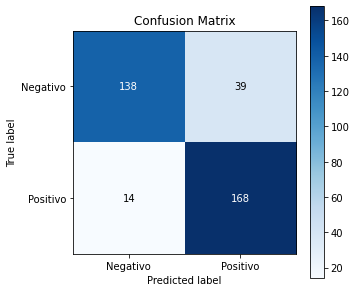

In [32]:
def label_to_str(label):
    if label == 0:
        return "Negativo"
    else:
        return "Positivo"
y_true = test2_df.label.values.tolist()
y_pred = predictions_df.label.values.tolist()
y_true = [label_to_str(label) for label in y_true]
y_pred = [label_to_str(label) for label in y_pred]
skplt.metrics.plot_confusion_matrix(y_true = y_true, y_pred = y_pred, figsize=(5,5))

### ¿Y si no hubieramos hecho fine-tuning con el conjunto de tweets?
En este apartado tomamos el modelo de análisis de sentimientos por defecto de HuggingFace preentrenado para clasificación con el dataset ['Stanford Sentiment Treebank'](https://nlp.stanford.edu/sentiment/index.html), el cual está formado por reseñas de películas. Como no ha sido entrenado con tweets, cabría esperar que su *accuracy* sea algo menor que el modelo que hemos preentrenado nosotros.

In [33]:
nlp = pipeline("sentiment-analysis")

In [0]:
predictions_by_bert = nlp(test2_df.sentence.values.tolist())

In [0]:
predictions_df = pd.DataFrame(predictions_by_bert)

In [0]:
decode_map = {"NEGATIVE": 0, "POSITIVE": 1}
def decode_sentiment(label):
    return decode_map[label]
predictions_df.label = predictions_df.label.apply(lambda x: decode_sentiment(x))

In [37]:
sklearn.metrics.accuracy_score(y_true = test2_df.label.values.tolist(), y_pred = predictions_df.label.values.tolist())

0.83008356545961

## 2- Carga del modelo de LSTM básica y evaluación en los conjuntos de test.

En esta sección, cargaremos el modelo LSTM ya entrenado en la libreta 3. En concreto cogeremos aquel que mostraba un mayor *accuracy* en el conjunto de validación. Tras cargar el modelo lo evaluaremos en los dos conjuntos de test que tenemos. 

In [0]:
model_name = "my_best_model_LSTM_Bi.03-0.83.h5"
model_path = models_dir + model_name

In [0]:
model_LSTM_Bi = tf.keras.models.load_model(model_path)

In [0]:
# Cargamos también el tokenizador que usamos durante el entrenamiento
with open(models_dir + 'tokenizer_LSTM.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

Cargamos los datos del primer conjunto de test y lo preprocesamos como es requerido por nuestro modelo LSTM (y como ya hicimos en la libreta 3).


In [0]:
dataset_name = "test_set.csv"
dataset_path = "/content/drive/My Drive/Datos/" + dataset_name
#dataset_path = "../Datos/" + dataset_name
test1_df = pd.read_csv(dataset_path)

In [0]:
x_test1, y_test1 = preprocesa_para_LSTM(test1_df, tokenizer)

Y evaluamos el modelo sobre este primer conjunto de test.



In [43]:
loss1_lstm, acc1_lstm = model_LSTM_Bi.evaluate(x_test1, y_test1, batch_size=30)
print('Test loss:', loss1_lstm)
print('Test accuracy:', acc1_lstm)

5334/5334 [==============================] - 25s 5ms/step - loss: 0.3737 - accuracy: 0.8339
Test loss: 0.373721718788147
Test accuracy: 0.8338500261306763


Hacemos lo mismo con el segundo conjunto de test (el cual ha sido etiquetado de forma manual y tiene tan solo 359 tweets).

In [0]:
# DATASET DECODING
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

dataset_name = "testdata.manual.2009.06.14.csv"
dataset_path = "/content/drive/My Drive/Datos/" + dataset_name
#dataset_path = "../Datos/" + dataset_name
test2_df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Nos quedamos solo con los comentarios positivos o negativos (ignoramos los neutros porque estos no los usan en el paper original).

In [45]:
test2_df = test2_df[test2_df["target"]!=2]
test2_df["target"].value_counts()

4    182
0    177
Name: target, dtype: int64

Preprocesamos como es requerido por nuestro modelo LSTM (y como ya hicimos en la libreta 3).


In [0]:
x_test2, y_test2 = preprocesa_para_LSTM(test2_df, tokenizer)

Y evaluamos el modelo sobre este segundo conjunto de test.


In [47]:
loss2_lstm, acc2_lstm = model_LSTM_Bi.evaluate(x_test2, y_test2, batch_size=30)
print('Test loss:', loss2_lstm)
print('Test accuracy:', acc2_lstm)

12/12 [==============================] - 0s 5ms/step - loss: 0.3755 - accuracy: 0.8329
Test loss: 0.3755266070365906
Test accuracy: 0.8328690528869629


#### Matriz de confusion

In [0]:
def prediction_to_label(prediction):
  if prediction < 0.5:
    return 0
  else:
    return 1

In [0]:
predictions = model_LSTM_Bi.predict(x_test2)
predicted_labels = [prediction_to_label(prediction[0]) for prediction in predictions]

In [50]:
sklearn.metrics.accuracy_score(y_true = test2_df.target.values.tolist(), y_pred = predicted_labels)

0.8328690807799443

In [51]:
c_matrix=sklearn.metrics.confusion_matrix(y_true = test2_df.target.values.tolist(), y_pred = predicted_labels)
c_matrix

array([[140,  37],
       [ 23, 159]])

In [52]:
tn, fp, fn, tp = c_matrix.ravel()
(tn, fp, fn, tp)

(140, 37, 23, 159)

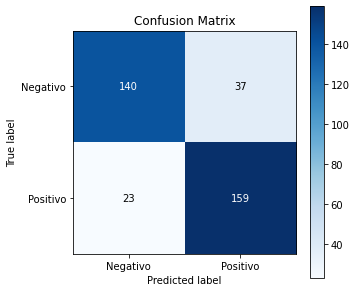

In [53]:
def label_to_str(label):
    if label == 0:
        return "Negativo"
    else:
        return "Positivo"
y_true = test2_df.target.values.tolist()
y_pred = predicted_labels
y_true = [label_to_str(label) for label in y_true]
y_pred = [label_to_str(label) for label in y_pred]
skplt.metrics.plot_confusion_matrix(y_true = y_true, y_pred = y_pred, figsize=(5,5))

## 3- Carga del modelo de LSTM con Word Embeddings y evaluación en los conjuntos de test.

En esta sección, cargaremos el modelo LSTM entrenado en la libreta 4 (el cual hace uso de Word Embeddings preentrenados). En concreto cogeremos aquel que mostraba un mayor *accuracy* en el conjunto de validación. Tras cargar el modelo lo evaluaremos en los dos conjuntos de test que tenemos. 

In [0]:
model_name = "my_best_model_LSTM_Bi_WE.09-0.83.h5"
model_path = models_dir + model_name

In [0]:
model_LSTM_Bi_WE = tf.keras.models.load_model(model_path)

Y evaluamos el modelo sobre este primer conjunto de test.

In [56]:
loss1_lstm_we, acc1_lstm_we = model_LSTM_Bi_WE.evaluate(x_test1, y_test1, batch_size=30)
print('Test loss:', loss1_lstm_we)
print('Test accuracy:', acc1_lstm_we)

5334/5334 [==============================] - 26s 5ms/step - loss: 0.3746 - accuracy: 0.8326
Test loss: 0.37458401918411255
Test accuracy: 0.8325625061988831


Y evaluamos el modelo sobre este segundo conjunto de test.


In [57]:
loss2_lstm_we, acc2_lstm_we = model_LSTM_Bi_WE.evaluate(x_test2, y_test2, batch_size=30)
print('Test loss:', loss2_lstm_we)
print('Test accuracy:', acc2_lstm_we)

12/12 [==============================] - 0s 4ms/step - loss: 0.3668 - accuracy: 0.8440
Test loss: 0.3667968213558197
Test accuracy: 0.844011127948761


#### Matriz de confusion

In [0]:
predictions = model_LSTM_Bi_WE.predict(x_test2)
predicted_labels = [prediction_to_label(prediction[0]) for prediction in predictions]

In [59]:
sklearn.metrics.accuracy_score(y_true = test2_df.target.values.tolist(), y_pred = predicted_labels)

0.8440111420612814

In [60]:
c_matrix=sklearn.metrics.confusion_matrix(y_true = test2_df.target.values.tolist(), y_pred = predicted_labels)
c_matrix

array([[143,  34],
       [ 22, 160]])

In [61]:
tn, fp, fn, tp = c_matrix.ravel()
(tn, fp, fn, tp)

(143, 34, 22, 160)

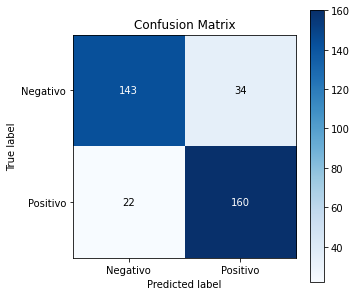

In [62]:
def label_to_str(label):
    if label == 0:
        return "Negativo"
    else:
        return "Positivo"
y_true = test2_df.target.values.tolist()
y_pred = predicted_labels
y_true = [label_to_str(label) for label in y_true]
y_pred = [label_to_str(label) for label in y_pred]
skplt.metrics.plot_confusion_matrix(y_true = y_true, y_pred = y_pred, figsize=(5,5))

## 4- Comparación del *accuracy* de los distintos modelos en los conjuntos test.

En esta sección hacemos dos gráficos de barras en los que mostramos el *accuracy* de los modelos en los dos conjuntos de test.

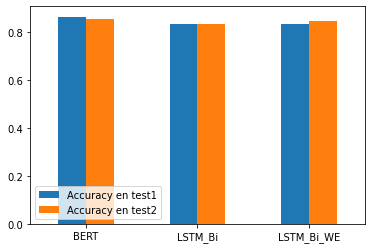

In [74]:
accuracy_test1 = [acc1_BERT, acc1_lstm, acc1_lstm_we]
accuracy_test2 = [acc2_BERT, acc2_lstm, acc2_lstm_we]
index = ['BERT', 'LSTM_Bi', 'LSTM_Bi_WE']
df = pd.DataFrame({'Accuracy en test1': accuracy_test1, 'Accuracy en test2': accuracy_test2}, index=index)
ax = df.plot.bar(rot=0).legend(loc='lower left')#,bbox_to_anchor=(1.0, 0.5))

Si restringimos el eje y (el *accuracy*) a $(0.8, 0.9)$ veremos mejor las diferencias.



(0.8, 0.9)

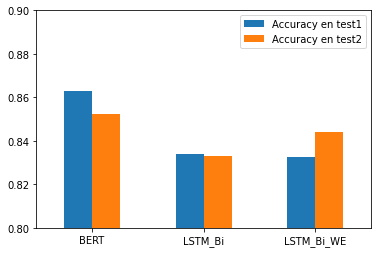

In [78]:
ax = df.plot.bar(rot=0).legend(loc='upper right')
plt.ylim(0.8, 0.9)

También los podemos representar por separado (los dos conjuntos de entrenamiento).


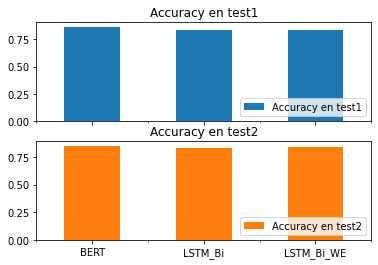

In [87]:
axes = df.plot.bar(rot=0, subplots=True)
axes[0].legend(loc='lower right') 
axes[1].legend(loc='lower right')  

## 5- Análisis de los datos recopilados durante los entrenamientos.

En esta sección analizaremos el historico de datos que recopilamos durante el entrenamiento de cada uno de los modelos.

### 5.1- Entrenamiento de BERT

Cargamos en primer lugar el histórico de datos recopilados durante el entrenamiento de BERT.

In [0]:
history_dir = "/content/drive/My Drive/datos_de_entrenamientos/"
history_path = history_dir + "history_with_times_BERT.json"
history_BERT = pd.read_json(path_or_buf=history_path)

In [89]:
history_BERT

,loss,accuracy,val_loss,val_accuracy,times
0,0.345548,0.848331,0.323767,0.861344,7729.534623
1,0.290168,0.876339,0.332546,0.862075,7713.080625
2,0.249771,0.896404,0.356749,0.859175,7665.665296
3,0.216663,0.911868,0.388973,0.857944,7668.061312
4,0.189929,0.923989,0.422314,0.855456,7684.038738
5,0.169763,0.932598,0.466934,0.850569,7699.367078


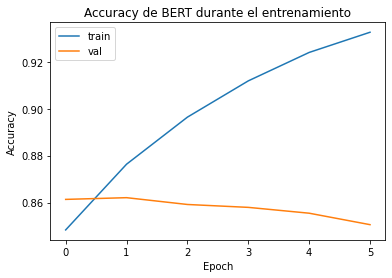

In [91]:
plt.plot(history_BERT['accuracy'])
plt.plot(history_BERT['val_accuracy'])
plt.title('Accuracy de BERT durante el entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

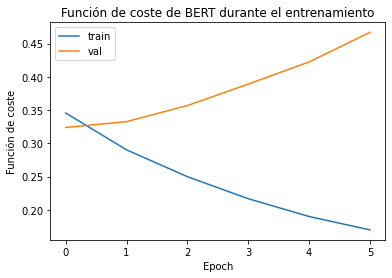

In [92]:
plt.plot(history_BERT['loss'])
plt.plot(history_BERT['val_loss'])
plt.title('Función de coste de BERT durante el entrenamiento')
plt.ylabel('Función de coste')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Creamos una función para representar las dos graficas al lado.

In [0]:
def plot_train_val_data(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
  ax1.plot(history['accuracy'])
  ax1.plot(history['val_accuracy'])
  ax1.set_title('Accuracy de BERT durante el entrenamiento')
  ax1.set_ylabel('Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.legend(['train', 'val'], loc='upper left')

  ax2.plot(history['loss'])
  ax2.plot(history['val_loss'])
  ax2.set_title('Función de coste de BERT durante el entrenamiento')
  ax2.set_ylabel('Función de coste')
  ax2.set_xlabel('Epoch')
  ax2.legend(['train', 'val'], loc='upper left')
  #plt.show()

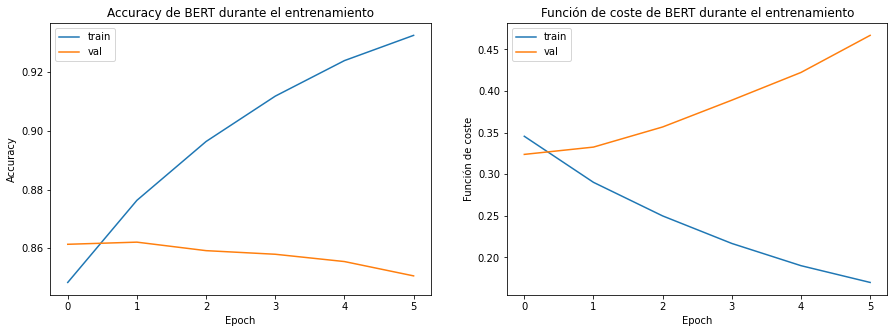

In [103]:
plot_train_val_data(history_BERT)

Respecto a los tiempos que ha tardado en ejecutarse cada época, podemos hacer su media y su desviación típica, así como representarlos en un gráfico de barras.

In [104]:
history_BERT['times'].mean()

7693.291278719899

In [107]:
history_BERT['times'].std()

25.40657075034842

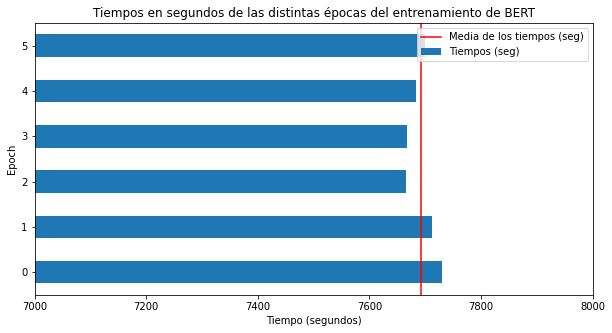

In [172]:
history_BERT['times'].plot.barh(figsize = (10,5), xlim=(7000, 8000))
plt.title('Tiempos en segundos de las distintas épocas del entrenamiento de BERT')
plt.ylabel('Epoch')
plt.xlabel('Tiempo (segundos)')
plt.axvline(x=history_BERT['times'].mean() , c='r')
plt.legend(['Media de los tiempos (seg)','Tiempos (seg)'], loc='upper right')
plt.show()

### 5.2- Entrenamiento de la LSTM bidireccional básica

Cargamos en primer lugar el histórico de datos recopilados durante el entrenamiento de esta red neuronal.

In [0]:
history_path = history_dir + "history_LSTM_Bi_with_times.csv"
history_LSTM = pd.read_csv(history_path, index_col=0)

In [136]:
history_LSTM

,loss,accuracy,val_loss,val_accuracy,times
0,0.406861,0.814927,0.378229,0.829800,1577.612016
1,0.361261,0.840847,0.371101,0.834638,1560.110505
2,0.337109,0.853740,0.376348,0.831100,1555.884030
3,0.316792,0.863922,0.382415,0.831975,1543.289702
4,0.299333,0.872939,0.388498,0.829550,1542.700771
5,0.283780,0.880177,0.399679,0.828150,1546.004563
6,0.270821,0.886291,0.415312,0.825262,1557.356287
7,0.260113,0.891230,0.418778,0.823706,1564.616673


Creamos una función para representar las dos graficas al lado.

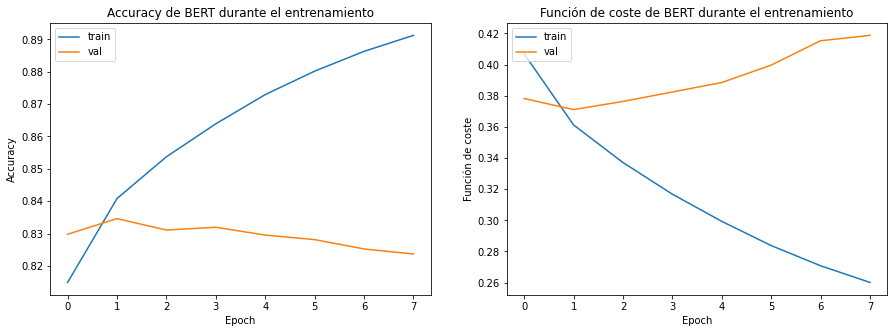

In [137]:
plot_train_val_data(history_LSTM)

Respecto a los tiempos que ha tardado en ejecutarse cada época, podemos hacer su media y su desviación típica, así como representarlos en un gráfico de barras.

In [138]:
history_LSTM['times'].mean()

1555.946818381548

In [139]:
history_LSTM['times'].std()

11.942617545241632

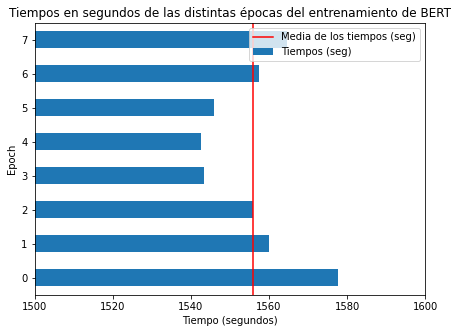

In [174]:
history_LSTM['times'].plot.barh(figsize = (7,5), xlim=(1500, 1600))
plt.title('Tiempos en segundos de las distintas épocas del entrenamiento de BERT')
plt.ylabel('Epoch')
plt.xlabel('Tiempo (segundos)')
plt.axvline(x=history_LSTM['times'].mean(), c='r')
plt.legend(['Media de los tiempos (seg)','Tiempos (seg)'], loc='upper right')
plt.show()

### 5.3- Entrenamiento de la LSTM bidireccional con Word Embeddings preentrenados.

Cargamos en primer lugar el histórico de datos recopilados durante el entrenamiento de esta red neuronal.

In [0]:
history_path = history_dir + "history_LSTM_Bi_WE_with_times.csv"
history_LSTM_WE = pd.read_csv(history_path, index_col=0)

In [148]:
history_LSTM_WE

,loss,accuracy,val_loss,val_accuracy,times
0,0.419442,0.806927,0.390838,0.823500,381.385000
1,0.384470,0.826697,0.378699,0.829356,373.171792
2,0.372340,0.833673,0.375309,0.832025,373.383518
3,0.364484,0.837668,0.377391,0.830387,364.366945
4,0.359072,0.840523,0.375273,0.832050,370.713228
5,0.354643,0.842912,0.373484,0.832969,369.809293
6,0.351082,0.844605,0.374886,0.831569,366.309370
7,0.348174,0.846277,0.375204,0.831519,366.945832
8,0.345734,0.847591,0.374238,0.833569,371.344284
9,0.343779,0.848465,0.375380,0.831438,368.507139


Creamos una función para representar las dos graficas al lado.

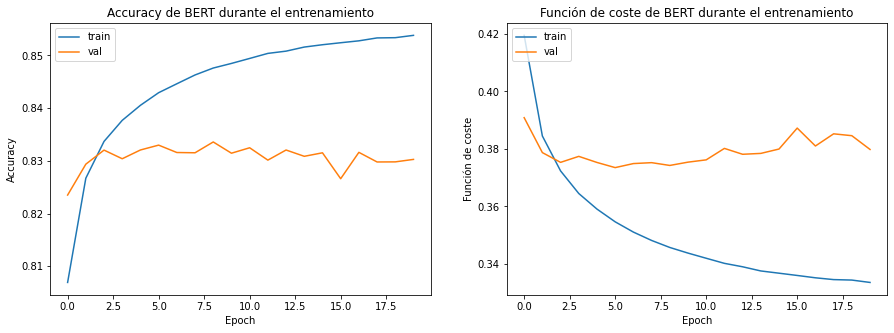

In [149]:
plot_train_val_data(history_LSTM_WE)

Respecto a los tiempos que ha tardado en ejecutarse cada época, podemos hacer su media y su desviación típica, así como representarlos en un gráfico de barras.

In [153]:
history_LSTM_WE['times'].mean()

365.7272800207138

In [154]:
history_LSTM_WE['times'].std()

6.505752834413273

In [161]:
round(history_LSTM_WE['times'].mean(), 3)

365.727

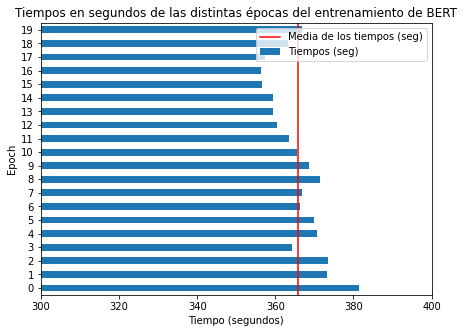

In [175]:
history_LSTM_WE['times'].plot.barh(figsize = (7,5), xlim=(300, 400))
plt.title('Tiempos en segundos de las distintas épocas del entrenamiento de BERT')
plt.ylabel('Epoch')
plt.xlabel('Tiempo (segundos)')
plt.axvline(x=history_LSTM_WE['times'].mean(), c='r')
plt.legend(['Media de los tiempos (seg)','Tiempos (seg)'], loc='upper right')
plt.show()

## 5.4- Comparación del *accuracy* y tiempos de entrenamiento por época de entrenamiento.

En esta sección comparamos los datos recopilados en los entrenamientos de los distintos modelos con el objetivo de hacernos una idea de cuáles son más rápidos de entrenar y cuando empieza a sobreajustar cada modelo.

En primer lugar podemos representar el accuracy y la función de coste durante el entrenamiento de todos los modelos.

In [0]:
def plot_train_val_data(histories, model_names):
  legend_names = []
  for name in model_names:
    legend_names.append('train' + name)
    legend_names.append('val' + name)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
  for history in histories:
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
  ax1.set_title('Accuracy de los modelos durante el entrenamiento')
  ax1.set_ylabel('Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.legend(legend_names, loc='upper left')

  for history in histories:
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
  ax2.set_title('Función de coste de los modelos durante el entrenamiento')
  ax2.set_ylabel('Función de coste')
  ax2.set_xlabel('Epoch')
  ax2.legend(legend_names, loc='upper left')

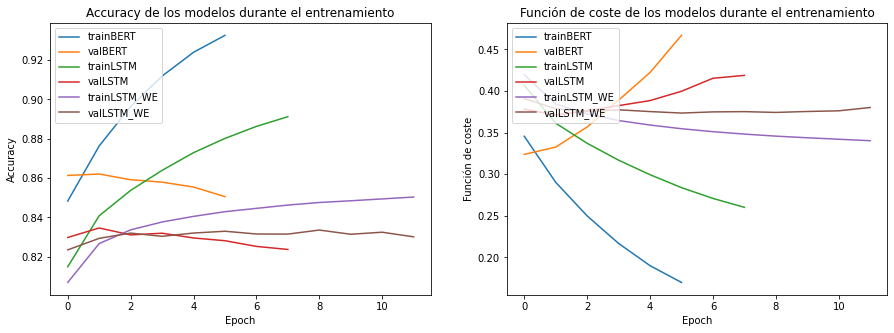

In [186]:
plot_train_val_data([history_BERT, history_LSTM, history_LSTM_WE.iloc[0:12]], model_names =["BERT", "LSTM", "LSTM_WE"])

Podemos representar también el *accuracy* en un gráfico de barras.

In [0]:
accuracy_BERT = list(history_BERT.val_accuracy.values) + [0]*14
accuracy_LSTM = list(history_LSTM.val_accuracy.values) + [0] * 12
accuracy_LSTM_WE = list(history_LSTM_WE.val_accuracy.values)

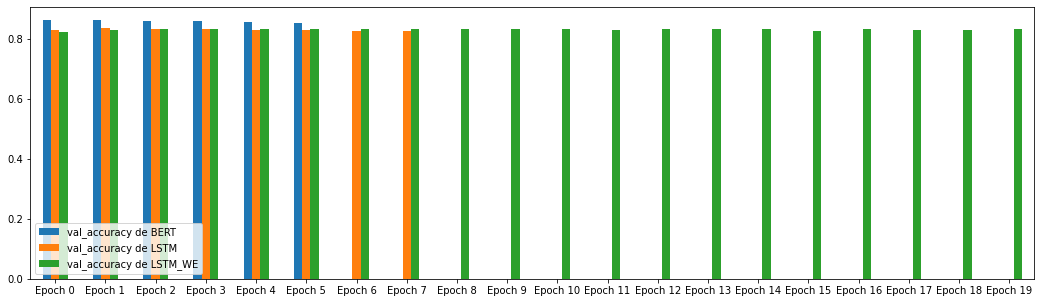

In [204]:
index = ["Epoch " + str(i) for i in range(20)]
df = pd.DataFrame({'val_accuracy de BERT': accuracy_BERT, 'val_accuracy de LSTM': accuracy_LSTM, 'val_accuracy de LSTM_WE': accuracy_LSTM_WE}, index=index)
ax = df.plot.bar(rot=0, figsize=(18,5)).legend(loc='lower left')

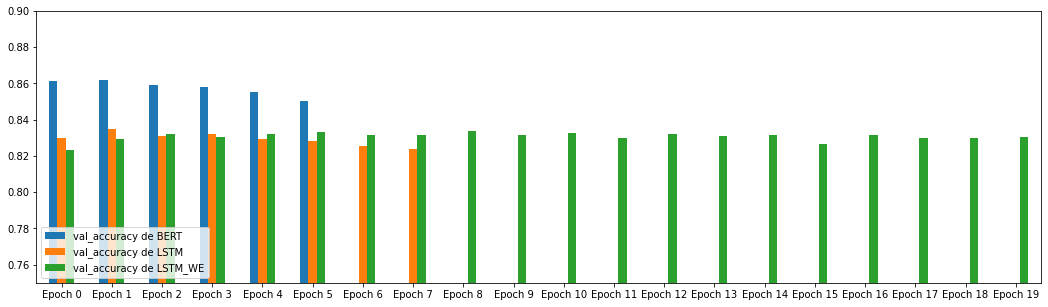

In [205]:
ax = df.plot.bar(rot=0, figsize=(18,5), ylim= (0.75,0.9)).legend(loc='lower left')

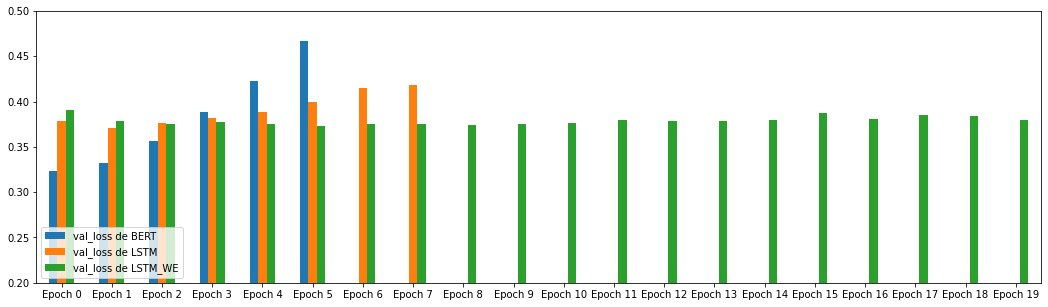

In [207]:
loss_BERT = list(history_BERT.val_loss.values) + [0]*14
loss_LSTM = list(history_LSTM.val_loss.values) + [0] * 12
loss_LSTM_WE = list(history_LSTM_WE.val_loss.values)
df = pd.DataFrame({'val_loss de BERT': loss_BERT, 'val_loss de LSTM': loss_LSTM, 'val_loss de LSTM_WE': loss_LSTM_WE}, index=index)
ax = df.plot.bar(rot=0, figsize=(18,5), ylim= (0.2,0.5)).legend(loc='lower left')

Finalmente, podemos representar graficamente los tiempos para hacernos una idea real de la diferencia en los tiempos de entrenamiento de los distintos modelos.

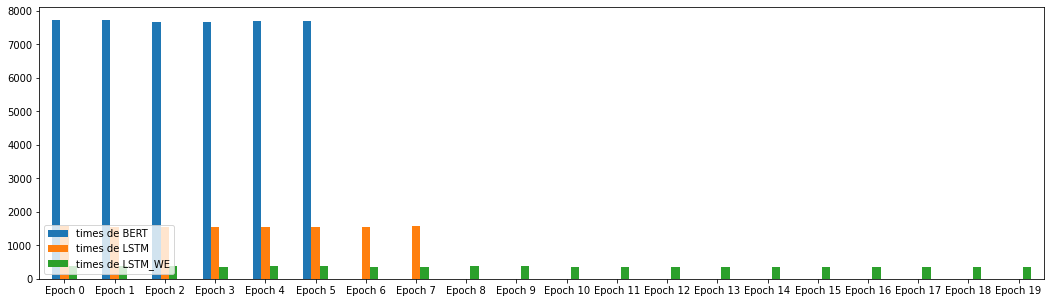

In [210]:
times_BERT = list(history_BERT.times.values) + [0]*14
times_LSTM = list(history_LSTM.times.values) + [0] * 12
times_LSTM_WE = list(history_LSTM_WE.times.values)
df = pd.DataFrame({'times de BERT': times_BERT, 'times de LSTM': times_LSTM, 'times de LSTM_WE': times_LSTM_WE}, index=index)
ax = df.plot.bar(rot=0, figsize=(18,5)).legend(loc='lower left')

In [211]:
sum(times_BERT)

46159.7476723194

In [212]:
sum(times_LSTM)

12447.574547052383

In [213]:
sum(times_LSTM_WE)

7314.545600414276